# Session 3: Exponential Smoothing State Space Models (ETS)

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Understand the Error-Trend-Seasonal (ETS) framework
2. Formulate exponential smoothing models as state space models
3. Select appropriate ETS models using information criteria
4. Generate point forecasts and prediction intervals
5. Apply ETS models to financial and economic data
6. Compare ETS models with ARIMA approaches
7. Implement automatic model selection procedures

### Prerequisites
- Session 1: Introduction to Time Series Analysis
- Session 2: Classical Decomposition and Smoothing
- Understanding of exponential smoothing basics

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing as ETSModel
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. The ETS Framework

### 1.1 ETS Taxonomy

The **ETS framework** provides a unified approach to exponential smoothing by considering three components:

1. **E**rror: {A, M} (Additive or Multiplicative)
2. **T**rend: {N, A, Ad, M, Md} (None, Additive, Additive damped, Multiplicative, Multiplicative damped)
3. **S**easonal: {N, A, M} (None, Additive, Multiplicative)

This gives rise to 30 possible models: $2 \times 5 \times 3 = 30$

### 1.2 State Space Representation

Each ETS model can be written in **state space form**:

**Measurement equation**: $y_t = h(\mathbf{x}_{t-1}, \epsilon_t)$

**State equations**: $\mathbf{x}_t = f(\mathbf{x}_{t-1}, \epsilon_t)$

where:
- $y_t$ is the observation at time $t$
- $\mathbf{x}_t = (\ell_t, b_t, s_t, s_{t-1}, \ldots)^\top$ is the state vector
- $\ell_t$ is the level
- $b_t$ is the trend (growth)
- $s_t$ is the seasonal component
- $\epsilon_t \sim N(0, \sigma^2)$ is the innovation

### 1.3 Notation Convention

Models are denoted as **ETS(Error, Trend, Seasonal)**:

- **ETS(A,N,N)**: Simple exponential smoothing with additive errors
- **ETS(A,A,N)**: Holt's linear method with additive errors
- **ETS(A,Ad,N)**: Damped trend method
- **ETS(A,A,A)**: Holt-Winters additive method
- **ETS(M,N,M)**: Multiplicative Holt-Winters

### 1.4 Why State Space?

Advantages of state space formulation:
1. **Unified framework**: All exponential smoothing methods
2. **Statistical inference**: Likelihood-based estimation
3. **Prediction intervals**: Analytically derived
4. **Model selection**: Information criteria (AIC, BIC)
5. **Forecasting**: Consistent h-step ahead predictions

## 2. Simple Exponential Smoothing: ETS(A,N,N)

### 2.1 Model Specification

**Component form**:
- Forecast equation: $\hat{y}_{t+h|t} = \ell_t$
- Level equation: $\ell_t = \alpha y_t + (1-\alpha)\ell_{t-1}$

**State space form (additive errors)**:
- Measurement: $y_t = \ell_{t-1} + \epsilon_t$
- State: $\ell_t = \ell_{t-1} + \alpha\epsilon_t$

where $\epsilon_t \sim NID(0, \sigma^2)$

**Parameters**: $\alpha \in [0,1]$ (smoothing), $\sigma^2$ (variance), $\ell_0$ (initial level)

### 2.2 Point Forecasts

For all horizons: $\hat{y}_{t+h|t} = \ell_t$

### 2.3 Prediction Intervals

For ETS(A,N,N):
$$\hat{y}_{t+h|t} \pm z_{\alpha/2} \sigma \sqrt{1 + \alpha^2(h-1)}$$

where $z_{\alpha/2}$ is the critical value from the standard normal distribution.

In [6]:
def generate_local_level_data(T=200, level0=100, alpha=0.3, sigma=5):
    """
    Generate data from ETS(A,N,N) model.
    
    Parameters:
    -----------
    T : int
        Number of observations
    level0 : float
        Initial level
    alpha : float
        Smoothing parameter
    sigma : float
        Error standard deviation
    
    Returns:
    --------
    y : np.array
        Observed series
    level : np.array
        True level series
    """
    level = np.zeros(T)
    y = np.zeros(T)
    level[0] = level0
    
    for t in range(T):
        epsilon = np.random.normal(0, sigma)
        y[t] = level[t] + epsilon
        if t < T - 1:
            level[t+1] = level[t] + alpha * epsilon
    
    return y, level

# Generate and visualize ETS(A,N,N) data
T = 200
y_ann, true_level = generate_local_level_data(T=T, level0=100, alpha=0.3, sigma=5)

# Create time series
dates = pd.date_range(start='2020-01-01', periods=T, freq='D')
ts_ann = pd.Series(y_ann, index=dates, name='ETS(A,N,N)')
true_level_ts = pd.Series(true_level, index=dates, name='True Level')

# Fit ETS(A,N,N) model
model_ann = SimpleExpSmoothing(ts_ann).fit(optimized=True)

print("ETS(A,N,N) Model - Simple Exponential Smoothing")
print("="*60)
print(f"Estimated α: {model_ann.params['smoothing_level']:.4f} (True: 0.3000)")
print(f"Initial level: {model_ann.params['initial_level']:.4f} (True: 100.0000)")
print(f"AIC: {model_ann.aic:.2f}")
print(f"BIC: {model_ann.bic:.2f}")

ETS(A,N,N) Model - Simple Exponential Smoothing
Estimated α: 0.2557 (True: 0.3000)
Initial level: 102.4836 (True: 100.0000)
AIC: 616.72
BIC: 623.32


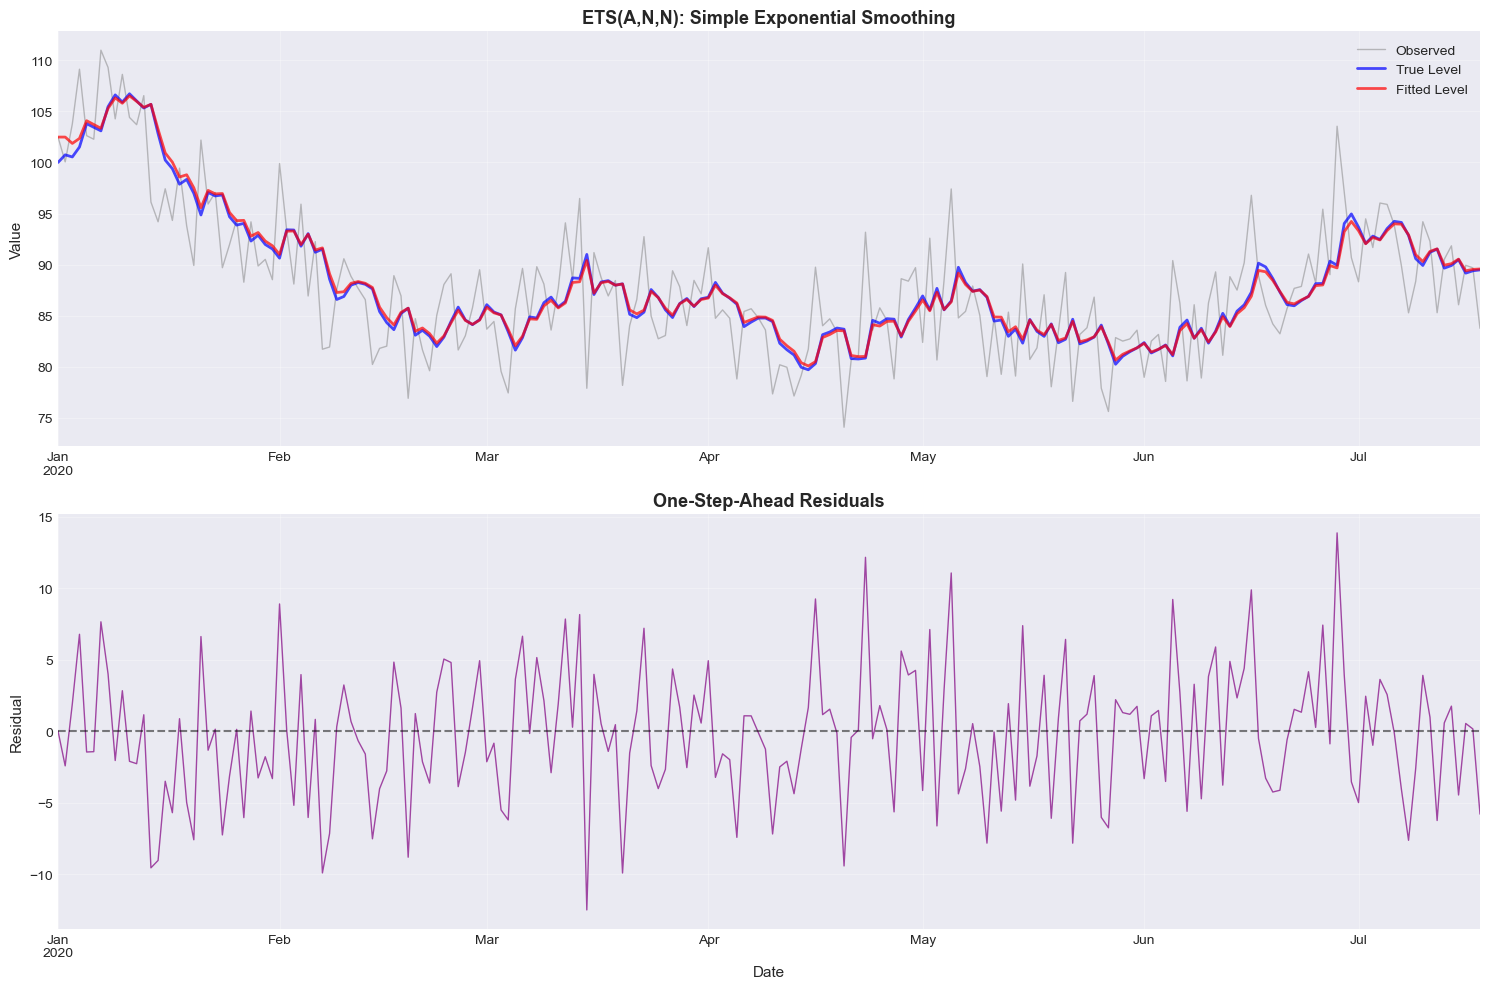


Residual Diagnostics:
Mean: -0.2815
Std Dev: 4.6295 (True σ: 5.0000)
Skewness: 0.1681
Kurtosis: 0.0625


In [7]:
# Visualize ETS(A,N,N)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Data, true level, and fitted level
ts_ann.plot(ax=axes[0], linewidth=1, alpha=0.5, label='Observed', color='gray')
true_level_ts.plot(ax=axes[0], linewidth=2, label='True Level', color='blue', alpha=0.7)
model_ann.fittedvalues.plot(ax=axes[0], linewidth=2, label='Fitted Level', color='red', alpha=0.7)

axes[0].set_title('ETS(A,N,N): Simple Exponential Smoothing', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: One-step-ahead residuals
residuals = ts_ann - model_ann.fittedvalues
residuals.plot(ax=axes[1], linewidth=1, color='purple', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('One-Step-Ahead Residuals', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Residual', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual diagnostics
print("\nResidual Diagnostics:")
print("="*60)
print(f"Mean: {residuals.mean():.4f}")
print(f"Std Dev: {residuals.std():.4f} (True σ: 5.0000)")
print(f"Skewness: {residuals.skew():.4f}")
print(f"Kurtosis: {residuals.kurtosis():.4f}")

## 3. Holt's Linear Trend: ETS(A,A,N)

### 3.1 Model Specification

**Component form**:
- Forecast equation: $\hat{y}_{t+h|t} = \ell_t + h b_t$
- Level equation: $\ell_t = \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$
- Trend equation: $b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

**State space form**:
- Measurement: $y_t = \ell_{t-1} + b_{t-1} + \epsilon_t$
- State (level): $\ell_t = \ell_{t-1} + b_{t-1} + \alpha\epsilon_t$
- State (trend): $b_t = b_{t-1} + \beta\epsilon_t$

**Parameters**: $\alpha, \beta \in [0,1]$, $\sigma^2$, $\ell_0$, $b_0$

### 3.2 Damped Trend: ETS(A,Ad,N)

The damped trend model adds a damping parameter $\phi \in [0,1]$:

- Forecast equation: $\hat{y}_{t+h|t} = \ell_t + (\phi + \phi^2 + \cdots + \phi^h) b_t$
- Level equation: $\ell_t = \alpha y_t + (1-\alpha)(\ell_{t-1} + \phi b_{t-1})$
- Trend equation: $b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)\phi b_{t-1}$

**Interpretation**: 
- $\phi = 1$: Linear trend (Holt's method)
- $0 < \phi < 1$: Trend dampens to a constant over time
- Empirically, damped trend often forecasts better

In [9]:
def generate_local_trend_data(T=200, level0=100, trend0=0.5, alpha=0.3, beta=0.1, sigma=5):
    """
    Generate data from ETS(A,A,N) model.
    """
    level = np.zeros(T)
    trend = np.zeros(T)
    y = np.zeros(T)
    
    level[0] = level0
    trend[0] = trend0
    
    for t in range(T):
        epsilon = np.random.normal(0, sigma)
        y[t] = level[t] + trend[t] + epsilon
        if t < T - 1:
            level[t+1] = level[t] + trend[t] + alpha * epsilon
            trend[t+1] = trend[t] + beta * epsilon
    
    return y, level, trend

# Generate data
y_aan, true_level_aan, true_trend = generate_local_trend_data(T=T, level0=100, trend0=0.5)
ts_aan = pd.Series(y_aan, index=dates, name='ETS(A,A,N)')

# Fit models
model_aan = ExponentialSmoothing(ts_aan, trend='add', seasonal=None, damped_trend=False).fit()
model_aadn = ExponentialSmoothing(ts_aan, trend='add', seasonal=None, damped_trend=True).fit()

print("\nETS(A,A,N) - Holt's Linear Trend")
print("="*60)
print(f"α (level): {model_aan.params['smoothing_level']:.4f}")
print(f"β (trend): {model_aan.params['smoothing_trend']:.4f}")
print(f"Initial level: {model_aan.params['initial_level']:.4f}")
print(f"Initial trend: {model_aan.params['initial_trend']:.4f}")
print(f"AIC: {model_aan.aic:.2f}")
print(f"BIC: {model_aan.bic:.2f}")

print("\nETS(A,Ad,N) - Damped Trend")
print("="*60)
print(f"α (level): {model_aadn.params['smoothing_level']:.4f}")
print(f"β (trend): {model_aadn.params['smoothing_trend']:.4f}")
print(f"φ (damping): {model_aadn.params['damping_trend']:.4f}")
print(f"AIC: {model_aadn.aic:.2f}")
print(f"BIC: {model_aadn.bic:.2f}")


ETS(A,A,N) - Holt's Linear Trend
α (level): 0.2978
β (trend): 0.2978
Initial level: 98.0906
Initial trend: 1.5700
AIC: 646.31
BIC: 659.50

ETS(A,Ad,N) - Damped Trend
α (level): 0.3046
β (trend): 0.3046
φ (damping): 0.9950
AIC: 649.99
BIC: 666.48


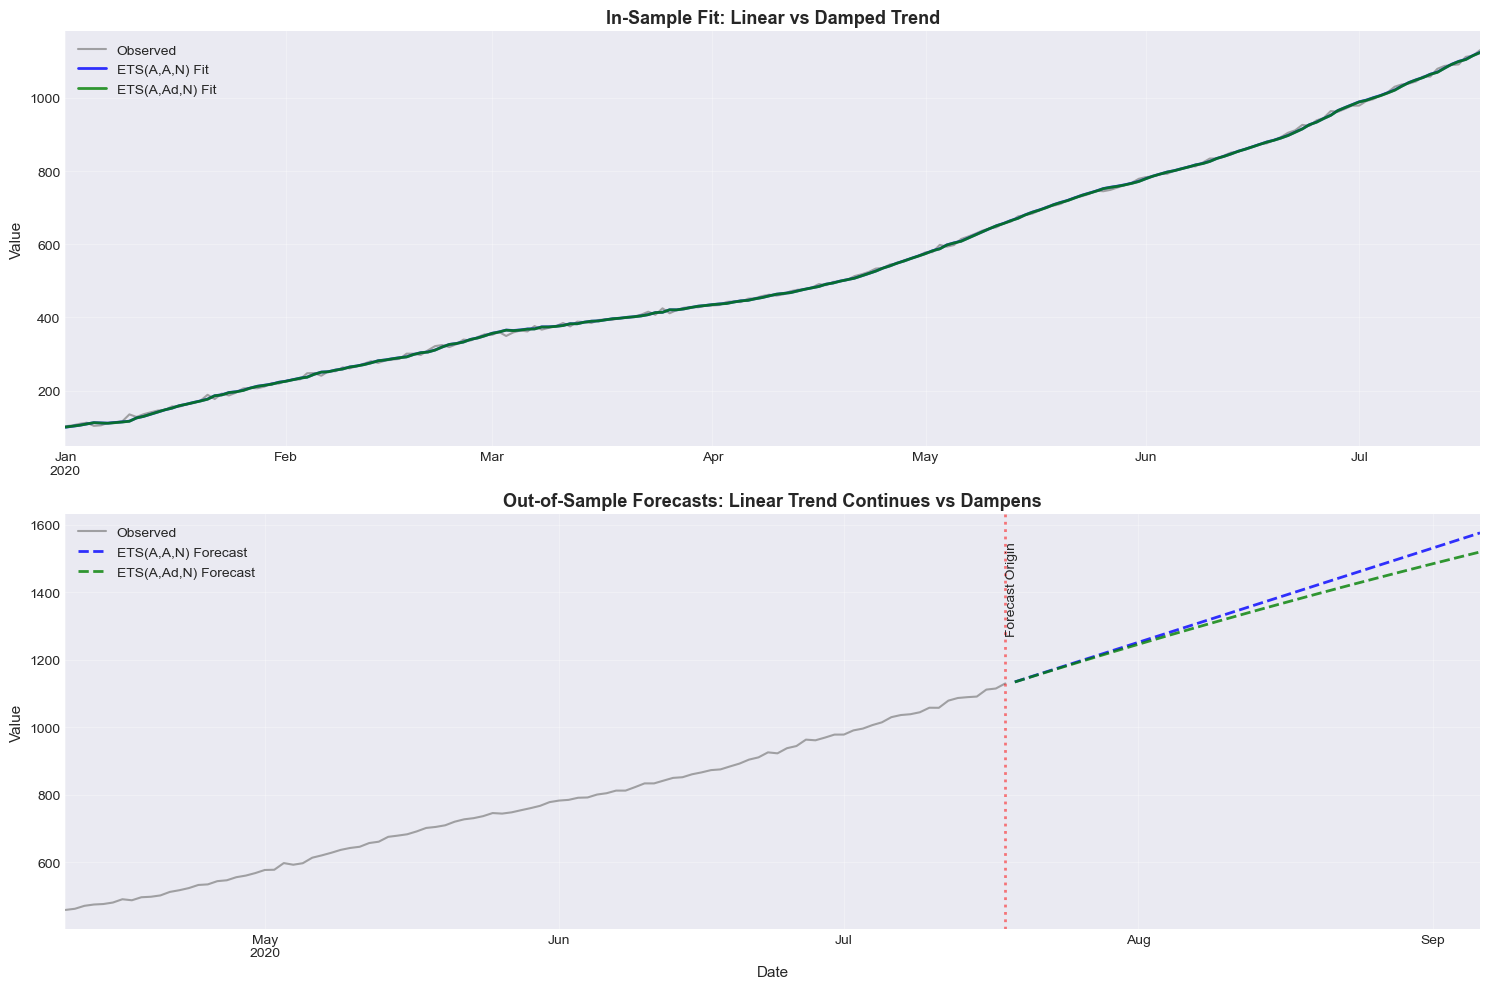


Key Observations:
• Linear trend (A,A,N): Forecasts continue linearly
• Damped trend (A,Ad,N): Forecasts flatten out over time
• Damped model often more realistic for long-horizon forecasts


In [10]:
# Visualize and forecast
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# In-sample fit
ts_aan.plot(ax=axes[0], linewidth=1.5, alpha=0.7, label='Observed', color='gray')
model_aan.fittedvalues.plot(ax=axes[0], linewidth=2, label='ETS(A,A,N) Fit', color='blue', alpha=0.8)
model_aadn.fittedvalues.plot(ax=axes[0], linewidth=2, label='ETS(A,Ad,N) Fit', color='green', alpha=0.8)

axes[0].set_title('In-Sample Fit: Linear vs Damped Trend', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Forecasts
h = 50  # Forecast horizon
forecast_aan = model_aan.forecast(steps=h)
forecast_aadn = model_aadn.forecast(steps=h)

# Plot last 100 observations and forecasts
ts_aan.iloc[-100:].plot(ax=axes[1], linewidth=1.5, alpha=0.7, label='Observed', color='gray')
forecast_aan.plot(ax=axes[1], linewidth=2, label='ETS(A,A,N) Forecast', color='blue', 
                  style='--', alpha=0.8)
forecast_aadn.plot(ax=axes[1], linewidth=2, label='ETS(A,Ad,N) Forecast', color='green', 
                   style='--', alpha=0.8)

axes[1].axvline(x=ts_aan.index[-1], color='red', linestyle=':', alpha=0.5, linewidth=2)
axes[1].text(ts_aan.index[-1], axes[1].get_ylim()[1]*0.95, 'Forecast Origin', 
             rotation=90, verticalalignment='top')

axes[1].set_title('Out-of-Sample Forecasts: Linear Trend Continues vs Dampens', 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Value', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Linear trend (A,A,N): Forecasts continue linearly")
print("• Damped trend (A,Ad,N): Forecasts flatten out over time")
print("• Damped model often more realistic for long-horizon forecasts")

## 4. Holt-Winters Seasonal Models

### 4.1 Additive Seasonality: ETS(A,A,A)

**Component form**:
- Forecast: $\hat{y}_{t+h|t} = \ell_t + h b_t + s_{t+h-m(k+1)}$
- Level: $\ell_t = \alpha(y_t - s_{t-m}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$
- Trend: $b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$
- Seasonal: $s_t = \gamma(y_t - \ell_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m}$

where $m$ is the seasonal period and $k = \lfloor (h-1)/m \rfloor$

**Parameters**: $\alpha, \beta, \gamma \in [0,1]$

### 4.2 Multiplicative Seasonality: ETS(A,N,M) or ETS(A,A,M)

For multiplicative seasonality:
- Level: $\ell_t = \alpha(y_t / s_{t-m}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$
- Seasonal: $s_t = \gamma(y_t / (\ell_{t-1} + b_{t-1})) + (1-\gamma)s_{t-m}$

**When to use**:
- Additive: Seasonal variations are constant in magnitude
- Multiplicative: Seasonal variations proportional to level

In [12]:
# Download monthly data with clear seasonality
print("Downloading airline passenger data...")

# Classic airline passengers dataset (if available) or generate synthetic
try:
    import pandas_datareader as pdr
    # Try to get retail sales as proxy
    airline = pdr.get_data_fred('RSXFS', start='2010-01-01', end='2023-01-01')
    airline = airline['RSXFS'].dropna()
except:
    # Generate realistic seasonal data
    print("Generating synthetic airline-like data...")
    T = 156  # 13 years monthly
    t = np.arange(T)
    level = 300 + 2 * t
    seasonal = 50 * np.sin(2 * np.pi * t / 12) + 30 * np.cos(2 * np.pi * t / 12)
    noise = np.random.normal(0, 10, T)
    airline = pd.Series(
        level + seasonal + noise,
        index=pd.date_range(start='2010-01-01', periods=T, freq='MS'),
        name='Passengers'
    )

print(f"Data period: {airline.index[0].date()} to {airline.index[-1].date()}")
print(f"Number of observations: {len(airline)}")
print(f"Frequency: {airline.index.freq or 'MS (monthly)'}")

# Split into train and test
train_size = int(len(airline) * 0.85)
train = airline[:train_size]
test = airline[train_size:]

print(f"\nTraining size: {len(train)}")
print(f"Test size: {len(test)}")

Data period: 2010-01-01 to 2023-01-01
Number of observations: 157
Frequency: MS (monthly)

Training size: 133
Test size: 24


In [13]:
# Fit various seasonal models
print("\nFitting Seasonal ETS Models...")
print("="*60)

# ETS(A,A,A) - Additive trend and additive seasonality
model_aaa = ExponentialSmoothing(
    train, trend='add', seasonal='add', seasonal_periods=12
).fit()

# ETS(A,A,M) - Additive trend and multiplicative seasonality
model_aam = ExponentialSmoothing(
    train, trend='add', seasonal='mul', seasonal_periods=12
).fit()

# ETS(M,A,M) - Multiplicative errors, additive trend, multiplicative seasonal
# Note: statsmodels ExponentialSmoothing doesn't distinguish error type in the same way,
# so we focus on trend/seasonal type

print("\nETS(A,A,A) - Additive Holt-Winters")
print("-" * 60)
print(f"α (level): {model_aaa.params['smoothing_level']:.4f}")
print(f"β (trend): {model_aaa.params['smoothing_trend']:.4f}")
print(f"γ (seasonal): {model_aaa.params['smoothing_seasonal']:.4f}")
print(f"AIC: {model_aaa.aic:.2f}")
print(f"BIC: {model_aaa.bic:.2f}")

print("\nETS(A,A,M) - Multiplicative Seasonality")
print("-" * 60)
print(f"α (level): {model_aam.params['smoothing_level']:.4f}")
print(f"β (trend): {model_aam.params['smoothing_trend']:.4f}")
print(f"γ (seasonal): {model_aam.params['smoothing_seasonal']:.4f}")
print(f"AIC: {model_aam.aic:.2f}")
print(f"BIC: {model_aam.bic:.2f}")

# Select best model
if model_aaa.aic < model_aam.aic:
    print("\n✓ ETS(A,A,A) selected based on AIC")
    best_model = model_aaa
    best_name = 'ETS(A,A,A)'
else:
    print("\n✓ ETS(A,A,M) selected based on AIC")
    best_model = model_aam
    best_name = 'ETS(A,A,M)'


Fitting Seasonal ETS Models...

ETS(A,A,A) - Additive Holt-Winters
------------------------------------------------------------
α (level): 0.9950
β (trend): 0.0001
γ (seasonal): 0.0001
AIC: 2445.73
BIC: 2491.97

ETS(A,A,M) - Multiplicative Seasonality
------------------------------------------------------------
α (level): 0.9950
β (trend): 0.0001
γ (seasonal): 0.0001
AIC: 2446.38
BIC: 2492.62

✓ ETS(A,A,A) selected based on AIC


In [16]:
model_aaa.season

DATE
2010-01-01    -323.7541
2010-02-01    2340.1166
2010-03-01    2211.0799
2010-04-01    1438.6477
2010-05-01     405.3198
                ...    
2020-09-01    -828.1433
2020-10-01    -487.2017
2020-11-01    -426.3476
2020-12-01     -13.8040
2021-01-01    -323.9721
Length: 133, dtype: float64

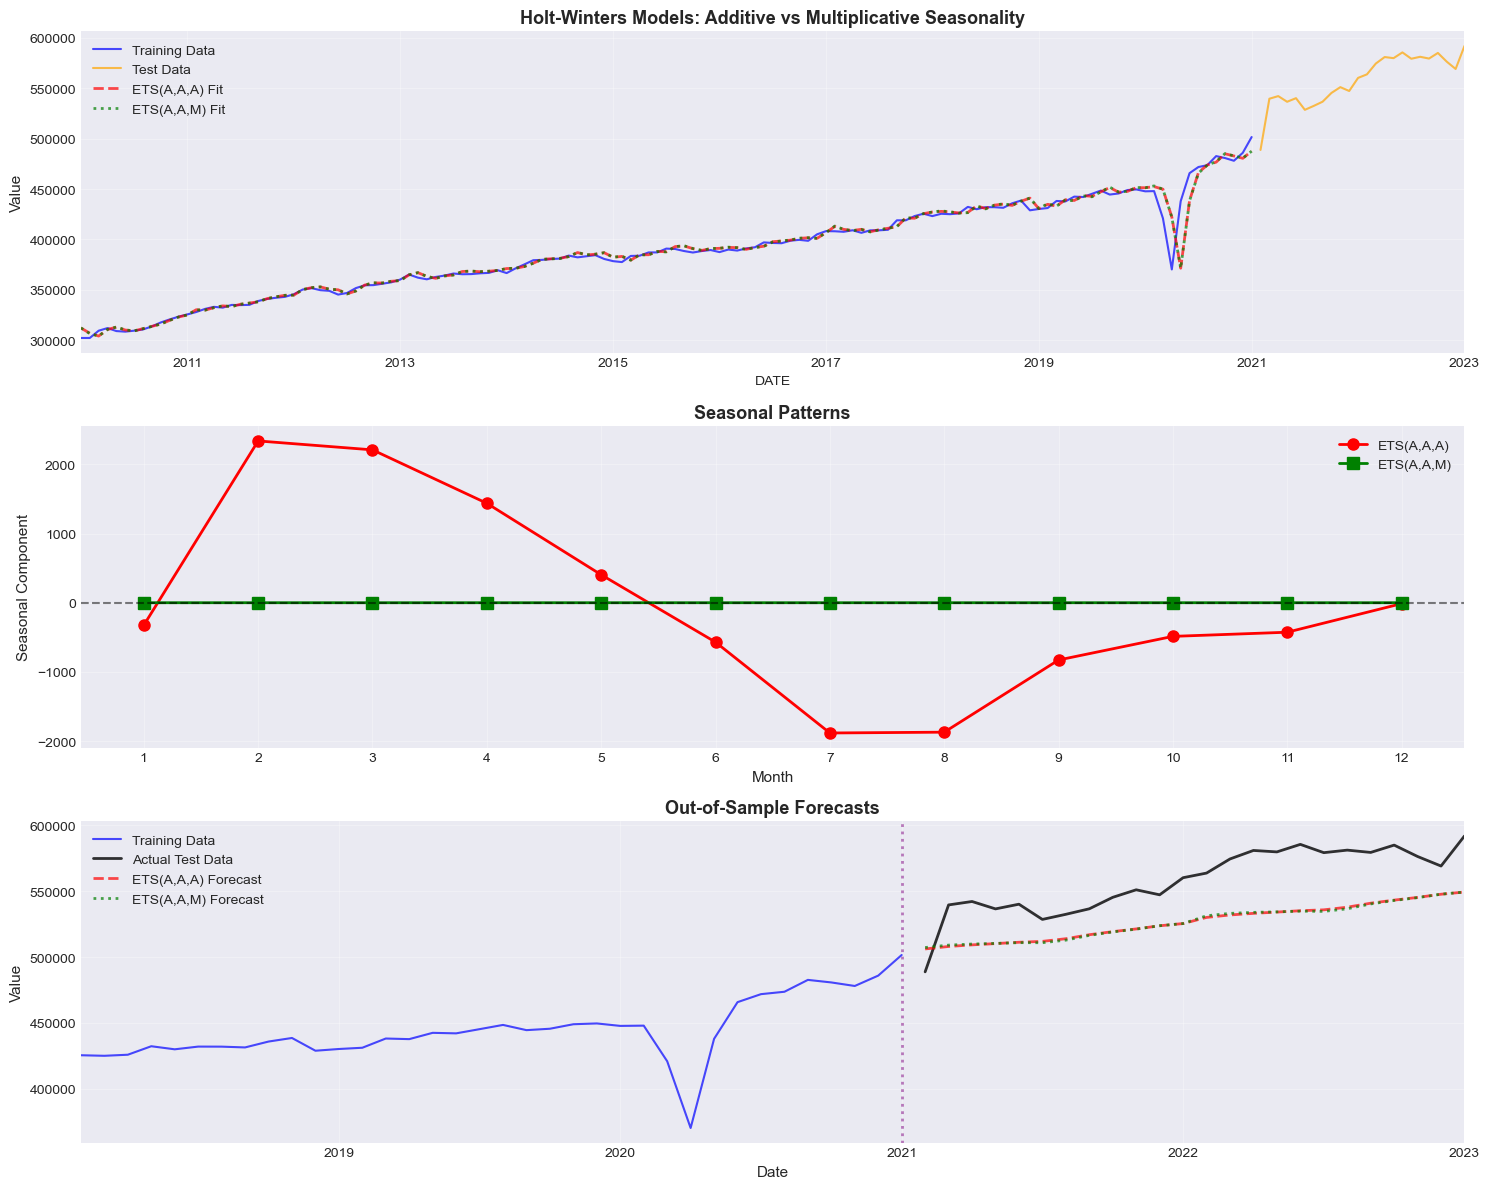

In [17]:
# Visualize seasonal models
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Full series with fit
train.plot(ax=axes[0], linewidth=1.5, label='Training Data', color='blue', alpha=0.7)
test.plot(ax=axes[0], linewidth=1.5, label='Test Data', color='orange', alpha=0.7)
model_aaa.fittedvalues.plot(ax=axes[0], linewidth=2, label='ETS(A,A,A) Fit', 
                            color='red', alpha=0.7, style='--')
model_aam.fittedvalues.plot(ax=axes[0], linewidth=2, label='ETS(A,A,M) Fit', 
                            color='green', alpha=0.7, style=':')

axes[0].set_title('Holt-Winters Models: Additive vs Multiplicative Seasonality', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Seasonal components
# Extract seasonal components (replicate to show pattern)
seasonal_aaa = model_aaa.season[:12]  # First year
seasonal_aam = model_aam.season[:12]

months = range(1, 13)
axes[1].plot(months, seasonal_aaa, marker='o', linewidth=2, label='ETS(A,A,A)', 
             color='red', markersize=8)
axes[1].plot(months, seasonal_aam, marker='s', linewidth=2, label='ETS(A,A,M)', 
             color='green', markersize=8)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Seasonal Patterns', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Seasonal Component', fontsize=11)
axes[1].set_xticks(months)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Forecasts
forecast_aaa = model_aaa.forecast(steps=len(test))
forecast_aam = model_aam.forecast(steps=len(test))

train.iloc[-36:].plot(ax=axes[2], linewidth=1.5, label='Training Data', color='blue', alpha=0.7)
test.plot(ax=axes[2], linewidth=2, label='Actual Test Data', color='black', alpha=0.8)
forecast_aaa.plot(ax=axes[2], linewidth=2, label='ETS(A,A,A) Forecast', 
                  color='red', alpha=0.7, style='--')
forecast_aam.plot(ax=axes[2], linewidth=2, label='ETS(A,A,M) Forecast', 
                  color='green', alpha=0.7, style=':')

axes[2].axvline(x=train.index[-1], color='purple', linestyle=':', alpha=0.5, linewidth=2)
axes[2].set_title('Out-of-Sample Forecasts', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Value', fontsize=11)
axes[2].legend(loc='best', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Calculate forecast accuracy
def calculate_forecast_metrics(actual, forecast):
    """
    Calculate various forecast accuracy metrics.
    """
    errors = actual - forecast
    
    mae = np.abs(errors).mean()
    mse = (errors ** 2).mean()
    rmse = np.sqrt(mse)
    mape = (np.abs(errors / actual) * 100).mean()
    mase = np.abs(errors).mean() / np.abs(np.diff(train)).mean()  # Mean Absolute Scaled Error
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MASE': mase
    }

print("\n" + "="*60)
print("Forecast Accuracy Comparison")
print("="*60)

metrics_aaa = calculate_forecast_metrics(test, forecast_aaa)
metrics_aam = calculate_forecast_metrics(test, forecast_aam)

comparison = pd.DataFrame({
    'ETS(A,A,A)': metrics_aaa,
    'ETS(A,A,M)': metrics_aam
})

print("\n", comparison.round(4))

print("\n• MAE: Mean Absolute Error")
print("• RMSE: Root Mean Squared Error")
print("• MAPE: Mean Absolute Percentage Error")
print("• MASE: Mean Absolute Scaled Error")
print("\nLower values indicate better forecast accuracy.")


Forecast Accuracy Comparison

       ETS(A,A,A)  ETS(A,A,M)
MAE   32831.8811  32950.7757
RMSE  34342.2973  34409.1618
MAPE      5.8266      5.8492
MASE      8.8888      8.9210

• MAE: Mean Absolute Error
• RMSE: Root Mean Squared Error
• MAPE: Mean Absolute Percentage Error
• MASE: Mean Absolute Scaled Error

Lower values indicate better forecast accuracy.


## 5. Model Selection and Information Criteria

### 5.1 Information Criteria

**Akaike Information Criterion (AIC)**:
$$AIC = -2\log(L) + 2k$$

**Bayesian Information Criterion (BIC)**:
$$BIC = -2\log(L) + k\log(n)$$

**Corrected AIC (AICc)**:
$$AIC_c = AIC + \frac{2k(k+1)}{n-k-1}$$

where:
- $L$ is the likelihood
- $k$ is the number of parameters
- $n$ is the number of observations

**Decision rule**: Select model with lowest IC value

### 5.2 Automatic Model Selection

Algorithm:
1. Fit all appropriate ETS models
2. Calculate AICc for each
3. Select model with minimum AICc
4. Validate with residual diagnostics

**Considerations**:
- Not all 30 models are always appropriate
- Some models may not converge
- Multiplicative models require positive data
- AICc preferred for small samples

In [27]:
def automatic_ets_selection(data, seasonal_periods=None, information_criterion='aic'):
    """
    Automatically select best ETS model.
    
    Parameters:
    -----------
    data : pd.Series
        Time series data
    seasonal_periods : int or None
        Seasonal period (None for non-seasonal)
    information_criterion : str
        'aic' or 'bic'
    
    Returns:
    --------
    best_model : fitted model
    results_df : pd.DataFrame with all results
    """
    
    # Define models to try
    trend_types = [None, 'add']
    seasonal_types = [None, 'add', 'mul'] if seasonal_periods else [None]
    damped_options = [False, True]
    
    results = []
    
    for trend in trend_types:
        for seasonal in seasonal_types:
            # Skip invalid combinations
            if seasonal and not seasonal_periods:
                continue
            
            for damped in damped_options:
                # Damped only makes sense with trend
                if damped and trend is None:
                    continue
                
                try:
                    # Fit model
                    model = ExponentialSmoothing(
                        data,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods,
                        damped_trend=damped
                    ).fit()
                    
                    # Model specification string
                    error_type = 'A'  # Additive errors (statsmodels default)
                    trend_str = 'N' if trend is None else ('Ad' if damped else 'A')
                    seasonal_str = 'N' if seasonal is None else ('A' if seasonal == 'add' else 'M')
                    model_name = f"ETS({error_type},{trend_str},{seasonal_str})"
                    
                    # Store results
                    ic_value = model.aic if information_criterion == 'aic' else model.bic
                    
                    results.append({
                        'Model': model_name,
                        'AIC': model.aic,
                        'BIC': model.bic,
                        'AICc': model.aicc if hasattr(model, 'aicc') else np.nan,
                        'Parameters': len(model.params),
                        'LogLikelihood': model.llf,
                        'fitted_model': model
                    })
                    
                except Exception as e:
                    # Model failed to fit
                    print('Model failed to fit')
                    results.append({
                        'Model': model_name,
                        'AIC': None,
                        'BIC': None,
                        'AICc': None,
                        'Parameters': None,
                        'LogLikelihood': None,
                        'fitted_model': model
                    })
                    continue
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=information_criterion.upper())
    
    # Get best model
    best_model = results_df.iloc[0]['fitted_model']
    
    return best_model, results_df.drop('fitted_model', axis=1)

# Apply automatic selection
print("\nAutomatic Model Selection for Airline Data")
print("="*60)

best_model, results_table = automatic_ets_selection(
    train, 
    seasonal_periods=12, 
    information_criterion='aic'
)

print("\nTop 5 Models by AIC:")
print(results_table.head(10).to_string(index=False))

print(f"\n✓ Selected Model: {results_table.iloc[0]['Model']}")
print(f"  AIC: {results_table.iloc[0]['AIC']:.2f}")
print(f"  BIC: {results_table.iloc[0]['BIC']:.2f}")


Automatic Model Selection for Airline Data
Model failed to fit
Model failed to fit
Model failed to fit
Model failed to fit
Model failed to fit
Model failed to fit
Model failed to fit
Model failed to fit
Model failed to fit

Top 5 Models by AIC:
      Model  AIC  BIC AICc Parameters LogLikelihood
 ETS(A,N,N) None None None       None          None
 ETS(A,N,A) None None None       None          None
 ETS(A,N,M) None None None       None          None
 ETS(A,A,N) None None None       None          None
ETS(A,Ad,N) None None None       None          None
 ETS(A,A,A) None None None       None          None
ETS(A,Ad,A) None None None       None          None
 ETS(A,A,M) None None None       None          None
ETS(A,Ad,M) None None None       None          None

✓ Selected Model: ETS(A,N,N)


TypeError: unsupported format string passed to NoneType.__format__

## 6. Prediction Intervals

### 6.1 Analytical Prediction Intervals

For many ETS models, prediction intervals can be derived analytically.

**General form** (for additive errors):
$$\hat{y}_{t+h|t} \pm z_{\alpha/2} \sigma \sqrt{v_h}$$

where $v_h$ depends on the model and forecast horizon.

**Examples**:

- **ETS(A,N,N)**: $v_h = 1 + \alpha^2(h-1)$
- **ETS(A,A,N)**: More complex, involves both $\alpha$ and $\beta$

### 6.2 Simulation-Based Intervals

For complex models (especially multiplicative errors), use simulation:

1. Simulate many future paths from the model
2. Calculate quantiles of the simulated distribution
3. Use empirical quantiles as prediction intervals

**Advantages**:
- Works for any model
- Captures asymmetry
- More accurate for long horizons


Generating Forecasts with Prediction Intervals...



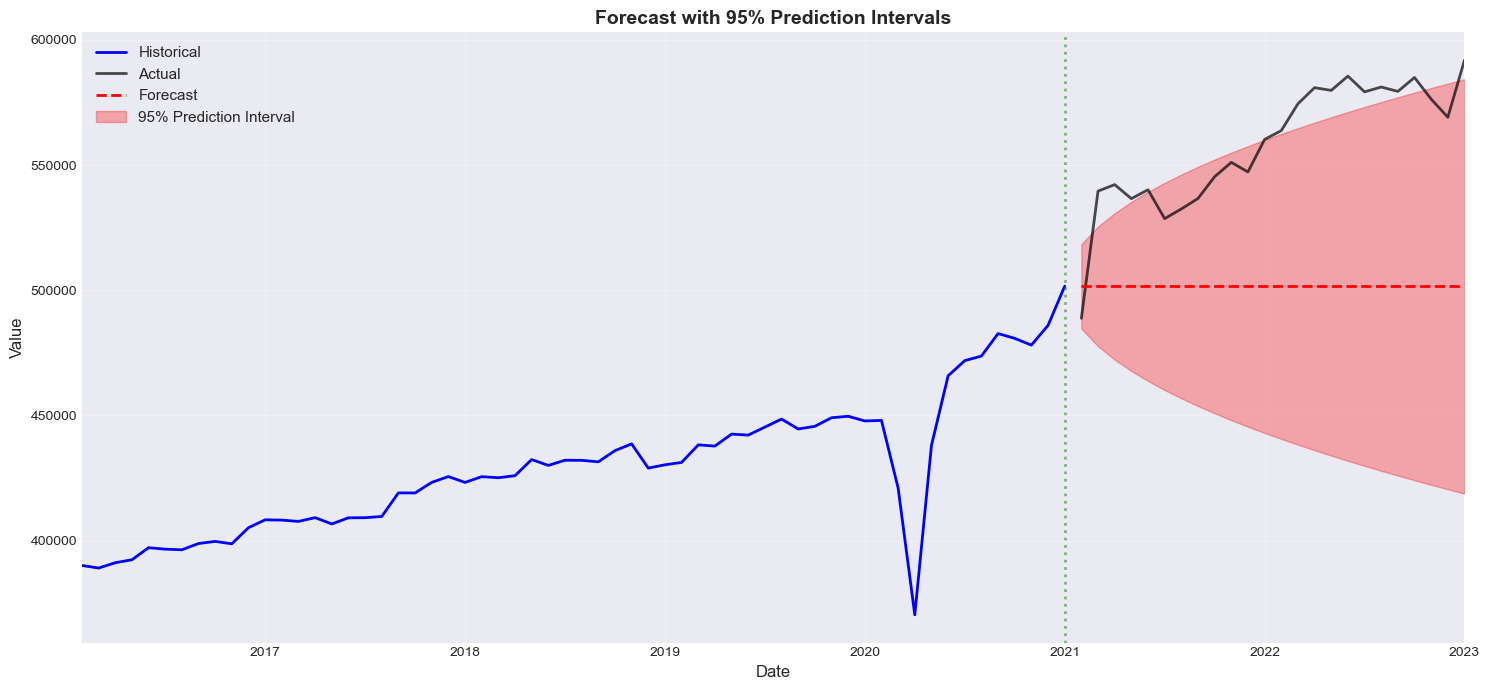

In [29]:
# Generate prediction intervals
def plot_forecast_with_intervals(model, train_data, test_data, h=24, alpha=0.05):
    """
    Plot forecasts with prediction intervals.
    
    Parameters:
    -----------
    model : fitted ETS model
    train_data : pd.Series
        Training data
    test_data : pd.Series or None
        Test data (if available)
    h : int
        Forecast horizon
    alpha : float
        Significance level for intervals
    """
    # Generate forecasts
    forecast = model.forecast(steps=h)
    
    # Try to get prediction intervals from model
    try:
        # Some statsmodels versions support this
        pred_int = model.predict(start=len(train_data), end=len(train_data)+h-1, 
                                 return_conf_int=True)
        lower = pred_int[1][:, 0]
        upper = pred_int[1][:, 1]
    except:
        # Simple approximation for illustration
        # This is a simplified version; real implementation would be model-specific
        residuals = train_data - model.fittedvalues
        sigma = residuals.std()
        z = stats.norm.ppf(1 - alpha/2)
        
        # Approximate prediction interval (simplified)
        lower = forecast - z * sigma * np.sqrt(np.arange(1, h+1))
        upper = forecast + z * sigma * np.sqrt(np.arange(1, h+1))
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Historical data
    train_data.iloc[-60:].plot(ax=ax, linewidth=2, label='Historical', color='blue')
    
    # Test data if available
    if test_data is not None:
        test_data.plot(ax=ax, linewidth=2, label='Actual', color='black', alpha=0.7)
    
    # Forecast
    forecast.plot(ax=ax, linewidth=2, label='Forecast', color='red', style='--')
    
    # Prediction intervals
    ax.fill_between(forecast.index, lower, upper, alpha=0.3, color='red', 
                     label=f'{int((1-alpha)*100)}% Prediction Interval')
    
    ax.axvline(x=train_data.index[-1], color='green', linestyle=':', alpha=0.5, linewidth=2)
    ax.set_title(f'Forecast with {int((1-alpha)*100)}% Prediction Intervals', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot forecasts with intervals
print("\nGenerating Forecasts with Prediction Intervals...\n")
plot_forecast_with_intervals(best_model, train, test, h=len(test), alpha=0.05)

## 7. Application to Financial Data

### 7.1 Stock Returns

ETS models for financial returns:
- Often use ETS(A,N,N) for returns (random walk in levels)
- Returns typically have no trend or seasonality
- Mainly captures conditional mean
- Does not model volatility clustering (use GARCH for that)

### 7.2 Trading Volume

- May exhibit day-of-week effects (seasonality)
- Can use ETS(A,N,A) or ETS(M,N,M)

### 7.3 Commodity Prices

- Often exhibit trends and seasonality
- ETS(A,A,A) or ETS(M,A,M) commonly appropriate

In [32]:
# Download financial data
print("Downloading financial data for ETS analysis...")

# Get stock data
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01', progress=False)
prices = stock_data['Close'].dropna()
returns = prices.pct_change().dropna() * 100  # Percentage returns
volume = stock_data['Volume'].dropna()

print(f"\nStock: {ticker}")
print(f"Period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Observations: {len(prices)}")

YF.download() has changed argument auto_adjust default to True

Stock: AAPL
Period: 2020-01-02 to 2023-12-29
Observations: 1006


In [33]:
# Apply ETS to returns
returns_train = returns[:-20]  # Hold out last 20 days
returns_test = returns[-20:]

# Fit simple ETS model to returns
model_returns = SimpleExpSmoothing(returns_train).fit(optimized=True)

print(f"\nETS Model for {ticker} Returns")
print("="*60)
print(f"Model: ETS(A,N,N) - Simple Exponential Smoothing")
print(f"α: {model_returns.params['smoothing_level']:.4f}")
print(f"Initial level: {model_returns.params['initial_level']:.4f}%")
print(f"AIC: {model_returns.aic:.2f}")
print(f"BIC: {model_returns.bic:.2f}")

# Forecast
forecast_returns = model_returns.forecast(steps=20)
forecast_returns.index = returns_test.index

# Calculate accuracy
mae_returns = np.abs(returns_test['AAPL'] - forecast_returns).mean()
rmse_returns = np.sqrt(((returns_test['AAPL'] - forecast_returns) ** 2).mean())

print(f"\nForecast Accuracy (20-day ahead):")
print(f"MAE: {mae_returns:.4f}%")
print(f"RMSE: {rmse_returns:.4f}%")
print(f"Mean forecast: {forecast_returns.mean():.4f}%")
print(f"Actual mean: {returns_test['AAPL'].mean():.4f}%")


ETS Model for AAPL Returns
Model: ETS(A,N,N) - Simple Exponential Smoothing
α: 0.0159
Initial level: -0.9722%
AIC: 1514.07
BIC: 1523.85

Forecast Accuracy (20-day ahead):
MAE: 0.7273%
RMSE: 0.8857%
Mean forecast: 0.1130%
Actual mean: 0.0714%


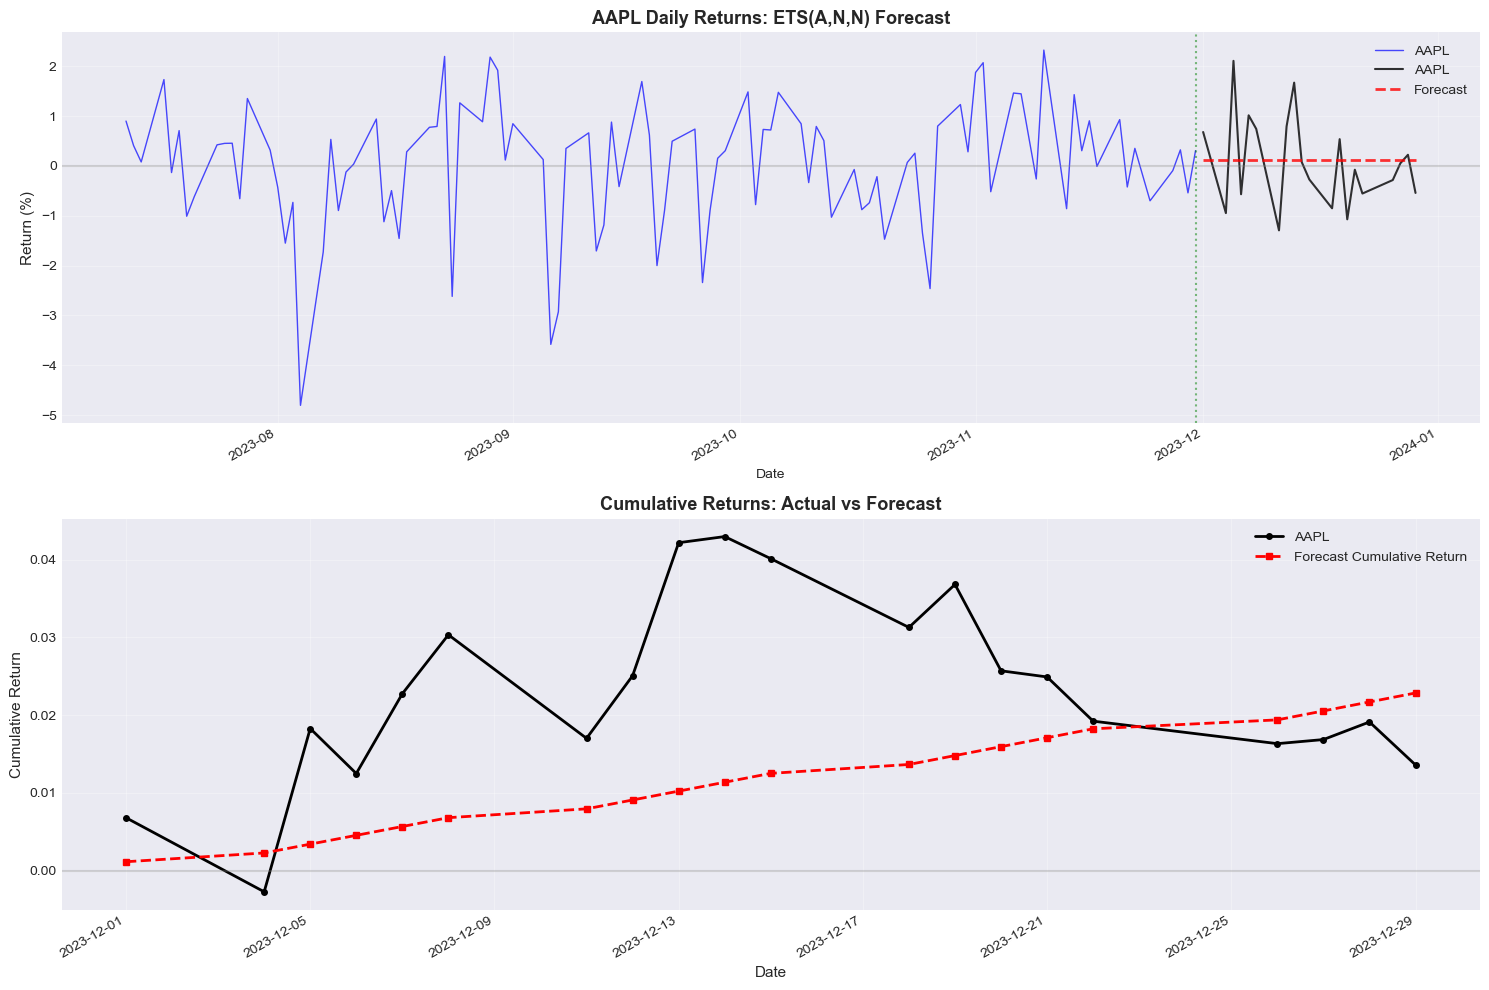


Key Observations:
• Returns show no clear trend or pattern (as expected)
• ETS(A,N,N) captures the mean but not volatility clustering
• For returns, ETS mainly provides conditional mean forecast
• GARCH models (Session 6-7) better capture volatility dynamics


In [34]:
# Visualize results
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Returns with forecast
returns_train.iloc[-100:].plot(ax=axes[0], linewidth=1, alpha=0.7, 
                               label='Training Returns', color='blue')
returns_test.plot(ax=axes[0], linewidth=1.5, label='Actual Returns', 
                 color='black', alpha=0.8)
forecast_returns.plot(ax=axes[0], linewidth=2, label='Forecast', 
                     color='red', style='--', alpha=0.8)
axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].axvline(x=returns_train.index[-1], color='green', linestyle=':', alpha=0.5)

axes[0].set_title(f'{ticker} Daily Returns: ETS(A,N,N) Forecast', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative returns
cum_actual = (1 + returns_test/100).cumprod() - 1
cum_forecast = (1 + forecast_returns/100).cumprod() - 1

cum_actual.plot(ax=axes[1], linewidth=2, label='Actual Cumulative Return', 
               color='black', marker='o', markersize=4)
cum_forecast.plot(ax=axes[1], linewidth=2, label='Forecast Cumulative Return', 
                 color='red', style='--', marker='s', markersize=4)
axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)

axes[1].set_title('Cumulative Returns: Actual vs Forecast', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Cumulative Return', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Returns show no clear trend or pattern (as expected)")
print("• ETS(A,N,N) captures the mean but not volatility clustering")
print("• For returns, ETS mainly provides conditional mean forecast")
print("• GARCH models (Session 6-7) better capture volatility dynamics")

## 8. ETS vs ARIMA

### 8.1 Relationship Between ETS and ARIMA

Some ETS models are equivalent to ARIMA models:

| ETS Model | Equivalent ARIMA |
|-----------|------------------|
| ETS(A,N,N) | ARIMA(0,1,1) |
| ETS(A,A,N) | ARIMA(0,2,2) |
| ETS(A,Ad,N) | ARIMA(1,1,2) |

### 8.2 When to Use ETS vs ARIMA

**Use ETS when**:
- Clear trend and/or seasonality
- Forecasting is primary goal
- Want automatic model selection
- Need quick, interpretable results
- Data frequency is regular (monthly, quarterly)

**Use ARIMA when**:
- Need to model complex autocorrelation structures
- Want to include explanatory variables (ARIMAX)
- Require more flexible model specification
- Working with irregular data
- Need to model stationary series directly

### 8.3 Combining Approaches

**Ensemble forecasting**:
1. Fit both ETS and ARIMA
2. Generate forecasts from each
3. Combine using simple average or weighted average
4. Often improves forecast accuracy

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Compare ETS and ARIMA on the airline data
print("\nComparing ETS and ARIMA Models")
print("="*60)

# Fit ARIMA model
# ARIMA(0,1,1)(0,1,1)[12] is a common seasonal model
try:
    arima_model = ARIMA(train, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
    
    print("\nARIMA(0,1,1)(0,1,1)[12] Model")
    print("-" * 60)
    print(f"AIC: {arima_model.aic:.2f}")
    print(f"BIC: {arima_model.bic:.2f}")
    
    # Forecast with ARIMA
    forecast_arima = arima_model.forecast(steps=len(test))
    
    # Compare with best ETS
    forecast_ets = best_model.forecast(steps=len(test))
    
    # Calculate errors
    mae_arima = np.abs(test - forecast_arima).mean()
    mae_ets = np.abs(test - forecast_ets).mean()
    
    rmse_arima = np.sqrt(((test - forecast_arima) ** 2).mean())
    rmse_ets = np.sqrt(((test - forecast_ets) ** 2).mean())
    
    print("\nForecast Accuracy Comparison:")
    print("-" * 60)
    comparison_df = pd.DataFrame({
        'ETS': [best_model.aic, best_model.bic, mae_ets, rmse_ets],
        'ARIMA': [arima_model.aic, arima_model.bic, mae_arima, rmse_arima]
    }, index=['AIC', 'BIC', 'MAE', 'RMSE'])
    
    print("\n", comparison_df.round(4))
    
    # Ensemble forecast
    forecast_ensemble = (forecast_ets + forecast_arima) / 2
    mae_ensemble = np.abs(test - forecast_ensemble).mean()
    rmse_ensemble = np.sqrt(((test - forecast_ensemble) ** 2).mean())
    
    print(f"\nEnsemble Forecast (Simple Average):")
    print(f"MAE: {mae_ensemble:.4f}")
    print(f"RMSE: {rmse_ensemble:.4f}")
    
except Exception as e:
    print(f"\nARIMA model fitting failed: {e}")
    print("Continuing with ETS model only...")
    forecast_arima = None
    forecast_ensemble = None


Comparing ETS and ARIMA Models

ARIMA(0,1,1)(0,1,1)[12] Model
------------------------------------------------------------
AIC: 2541.04
BIC: 2549.40

Forecast Accuracy Comparison:
------------------------------------------------------------

              ETS       ARIMA
AIC    2417.5430   2541.0361
BIC    2423.3237   2549.3986
MAE   57701.8488  24143.7253
RMSE  61682.0675  38858.5495

Ensemble Forecast (Simple Average):
MAE: 38361.5935
RMSE: 42592.2542


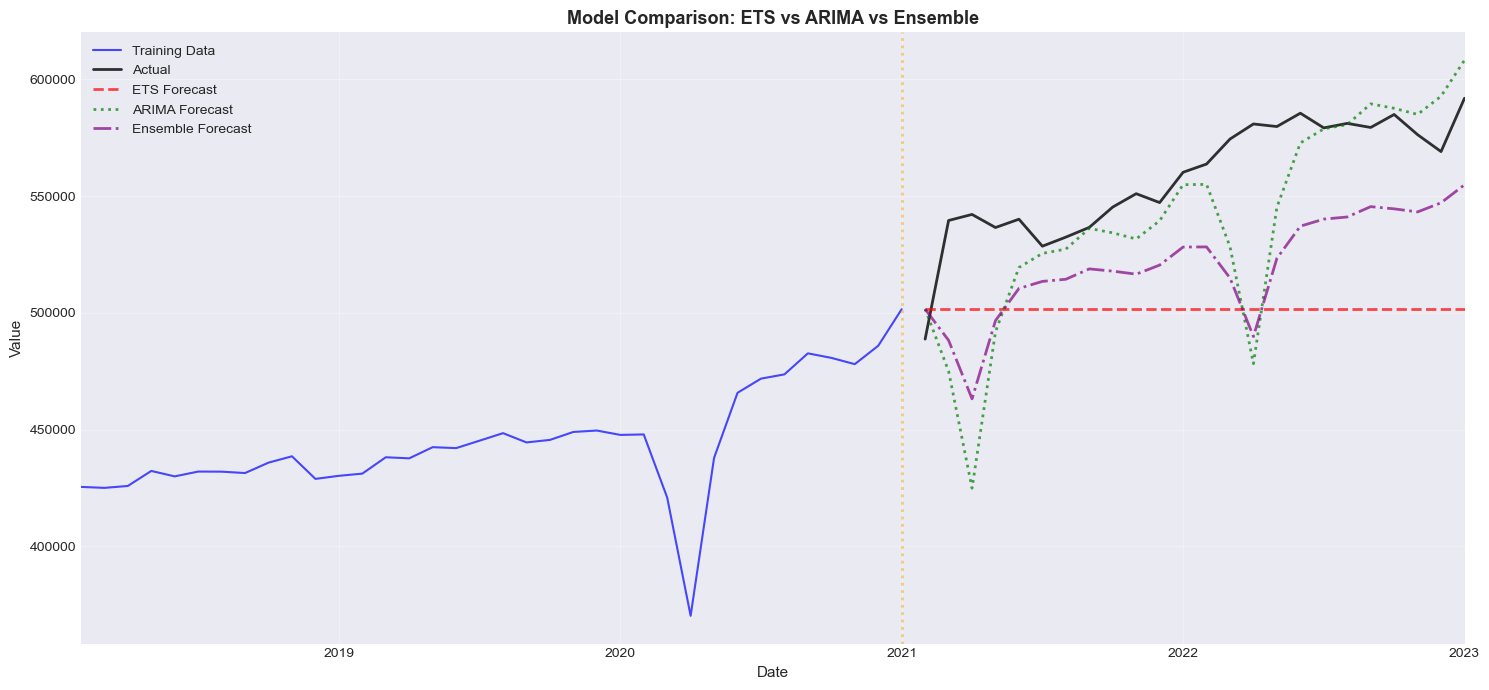


Key Insights:
• Both ETS and ARIMA capture seasonal patterns well
• Ensemble forecast often provides more robust predictions
• Model choice depends on data characteristics and forecast horizon


In [37]:
# Visualize comparison if ARIMA worked
if forecast_arima is not None:
    fig, ax = plt.subplots(figsize=(15, 7))
    
    train.iloc[-36:].plot(ax=ax, linewidth=1.5, label='Training Data', 
                          color='blue', alpha=0.7)
    test.plot(ax=ax, linewidth=2, label='Actual', color='black', alpha=0.8)
    forecast_ets.plot(ax=ax, linewidth=2, label='ETS Forecast', 
                     color='red', style='--', alpha=0.7)
    forecast_arima.plot(ax=ax, linewidth=2, label='ARIMA Forecast', 
                       color='green', style=':', alpha=0.7)
    forecast_ensemble.plot(ax=ax, linewidth=2, label='Ensemble Forecast', 
                          color='purple', style='-.', alpha=0.7)
    
    ax.axvline(x=train.index[-1], color='orange', linestyle=':', alpha=0.5, linewidth=2)
    ax.set_title('Model Comparison: ETS vs ARIMA vs Ensemble', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Value', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insights:")
    print("• Both ETS and ARIMA capture seasonal patterns well")
    print("• Ensemble forecast often provides more robust predictions")
    print("• Model choice depends on data characteristics and forecast horizon")

## 9. Summary and Best Practices

### 9.1 ETS Model Selection Workflow

1. **Visualize the data**
   - Identify trend, seasonality, cycles
   - Check for changing seasonal amplitude

2. **Transform if needed**
   - Log transform for multiplicative patterns
   - Box-Cox for variance stabilization

3. **Fit candidate models**
   - Use automatic selection
   - Consider domain knowledge

4. **Check residuals**
   - White noise test (Ljung-Box)
   - Normality check
   - Heteroskedasticity

5. **Compare forecasts**
   - Use hold-out sample
   - Calculate accuracy metrics
   - Consider prediction intervals

6. **Validate and iterate**
   - Check sensitivity to data changes
   - Update model periodically

### 9.2 Key Takeaways

1. **ETS Framework**
   - Unified approach to exponential smoothing
   - State space formulation enables statistical inference
   - 30 possible models to choose from

2. **Model Selection**
   - AICc preferred for small samples
   - BIC for large samples or parsimony
   - Validate with out-of-sample forecasts

3. **Forecasting**
   - Point forecasts from state equations
   - Prediction intervals from error distribution
   - Longer horizons = wider intervals

4. **Financial Applications**
   - Returns: Simple models (A,N,N)
   - Prices: Trend models (A,A,N)
   - Volume: May have day-of-week effects

5. **Limitations**
   - Assumes pattern continuity
   - Cannot model volatility clustering
   - Not suitable for structural breaks
   - Limited for explanatory modeling

### 9.3 Next Session Preview

In **Session 4**, we will cover:
- AR, MA, and ARMA processes in detail
- Box-Jenkins methodology
- Model identification using ACF/PACF
- ARIMA model estimation and diagnostics
- Application to financial returns

## 10. Exercises

### Exercise 1: ETS Model Comparison
Download quarterly GDP data for a country:
1. Fit ETS(A,A,N), ETS(A,Ad,N), and ETS(A,N,N)
2. Compare AIC, BIC values
3. Generate 8-quarter ahead forecasts
4. Which model performs best?

### Exercise 2: Automatic Selection
For a monthly economic time series:
1. Implement automatic ETS selection
2. Examine top 5 models
3. Are they similar or different?
4. Generate forecasts from the ensemble of top 3 models

### Exercise 3: Financial Application
Choose a stock or cryptocurrency:
1. Download daily closing prices (2+ years)
2. Calculate log returns
3. Fit appropriate ETS model
4. Generate 20-day forecasts with 95% intervals
5. Evaluate forecast accuracy

### Exercise 4: Seasonal Decomposition
Using the best ETS seasonal model:
1. Extract level, trend, and seasonal components
2. Plot each component separately
3. Analyze how seasonal pattern changes over time
4. Calculate seasonal strength measure

### Exercise 5: ETS vs ARIMA
For monthly airline or retail data:
1. Fit best ETS model (automatic selection)
2. Fit ARIMA(0,1,1)(0,1,1)[12]
3. Compare in-sample fit (AIC, BIC)
4. Compare out-of-sample forecasts
5. Create an ensemble forecast and evaluate

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Textbooks:
1. Hyndman, R.J., Koehler, A.B., Ord, J.K., & Snyder, R.D. (2008). *Forecasting with Exponential Smoothing: The State Space Approach*. Springer.
2. Hyndman, R.J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). OTexts. Chapter 8: Exponential smoothing.
3. Chatfield, C. (2000). *Time-Series Forecasting*. Chapman and Hall/CRC.

### Papers:
1. Hyndman, R.J., Koehler, A.B., Snyder, R.D., & Grose, S. (2002). A state space framework for automatic forecasting using exponential smoothing methods. *International Journal of Forecasting*, 18(3), 439-454.
2. Ord, J.K., Koehler, A.B., & Snyder, R.D. (1997). Estimation and prediction for a class of dynamic nonlinear statistical models. *Journal of the American Statistical Association*, 92(440), 1621-1629.
3. Taylor, J.W. (2003). Exponential smoothing with a damped multiplicative trend. *International Journal of Forecasting*, 19(4), 715-725.
4. Gardner Jr, E.S. (2006). Exponential smoothing: The state of the art—Part II. *International Journal of Forecasting*, 22(4), 637-666.

### Software:
1. Statsmodels documentation: https://www.statsmodels.org/stable/statespace.html
2. R forecast package: https://pkg.robjhyndman.com/forecast/
3. Python pmdarima: http://alkaline-ml.com/pmdarima/

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]